In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.


In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [3]:
import logging
import torch
from collections import OrderedDict
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
import detectron2.utils.comm as comm
from detectron2.structures import Instances
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)


from matplotlib import pyplot as plt
from PIL import Image

In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="OZmt7veKofDCRjgyQ5XE")
project = rf.workspace("csilab").project("csilab-braintumor-detection")
version = project.version(3)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...


In [6]:
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode
register_coco_instances("tumor_detection_train", {}, "/content/CsiLab-BrainTumor-Detection-3/train/_annotations.coco.json", "/content/CsiLab-BrainTumor-Detection-3/train")
register_coco_instances("tumor_detection_val", {}, "/content/CsiLab-BrainTumor-Detection-3/valid/_annotations.coco.json", "/content/CsiLab-BrainTumor-Detection-3/valid")
register_coco_instances("tumor_detection_test", {}, "/content/CsiLab-BrainTumor-Detection-3/test/_annotations.coco.json", "/content/CsiLab-BrainTumor-Detection-3/test")


WARNING [04/09 16:35:17 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/09 16:35:17 d2.data.datasets.coco]: Loaded 211 images in COCO format from /content/CsiLab-BrainTumor-Detection-3/train/_annotations.coco.json


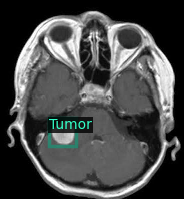

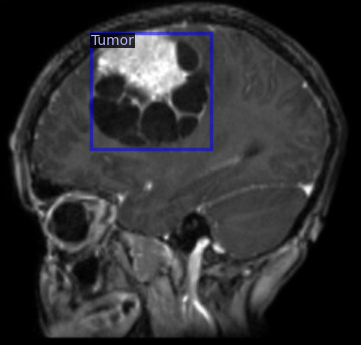

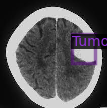

In [7]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("tumor_detection_train")
dataset_dicts = DatasetCatalog.get("tumor_detection_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [8]:
from detectron2.engine import DefaultTrainer


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("tumor_detection_train",)
cfg.DATASETS.TEST = ("tumor_detection_test",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.DEVICE = 'cuda'
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR

cfg.SOLVER.MAX_ITER = 2000 #Número de épocas que estou treinando
cfg.SOLVER.STEPS = []

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
PATIENCE = 500
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)




In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[04/09 16:35:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

backbone.bottom_up.res2.0.conv1.norm.{bias, running_mean, running_var, weight}
backbone.bottom_up.res2.0.conv1.weight
backbone.bottom_up.res2.0.conv2.norm.{bias, running_mean, running_var, weight}
backbone.bottom_up.res2.0.conv2.weight
backbone.bottom_up.res2.0.conv3.weight
backbone.bottom_up.res2.1.conv1.norm.{bias, running_mean, running_var, weight}
backbone.bottom_up.res2.1.conv1.weight
backbone.bottom_up.res2.1.conv2.norm.{bias, running_mean, running_var, weight}
backbone.bottom_up.res2.1.conv2.weight
backbone.bottom_up.res2.1.conv3.weight
backbone.bottom_up.res2.2.conv1.norm.{bias, running_mean, running_var, weight}
backbone.bottom_up.res2.2.conv1.weight
backbone.bottom_up.res2.2.conv2.norm.{bias, running_mean, running_var, weight}
backbone.bottom_up.res2.2.conv2.weight
backbone.bottom_up.res2.2.conv3.weight
backbone.bottom_up.res3.0.conv1.norm.{bias, running_mean, running_var, weight}
backbone.bottom_up.res3.0.conv1.weight
backbone.bottom_up.res3.0.conv2.norm.{bias, running_mean,

[04/09 16:35:35 d2.engine.train_loop]: Starting training from iteration 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/09 16:36:01 d2.utils.events]:  eta: 0:38:40  iter: 19  total_loss: 9.83  loss_cls: 1.126  loss_box_reg: 0.006885  loss_rpn_cls: 4.53  loss_rpn_loc: 0.5032    time: 1.2819  last_time: 1.1513  data_time: 0.0317  last_data_time: 0.0049   lr: 4.7455e-06  max_mem: 5369M
[04/09 16:36:30 d2.utils.events]:  eta: 0:39:45  iter: 39  total_loss: 2.869  loss_cls: 0.9304  loss_box_reg: 0.006536  loss_rpn_cls: 1.159  loss_rpn_loc: 0.1651    time: 1.2779  last_time: 1.2441  data_time: 0.0100  last_data_time: 0.0124   lr: 9.7405e-06  max_mem: 5369M
[04/09 16:36:59 d2.utils.events]:  eta: 0:42:26  iter: 59  total_loss: 0.3845  loss_cls: 0.1359  loss_box_reg: 0.002695  loss_rpn_cls: 0.123  loss_rpn_loc: 0.04515    time: 1.3404  last_time: 1.3911  data_time: 0.0135  last_data_time: 0.0058   lr: 1.4736e-05  max_mem: 5369M
[04/09 16:37:24 d2.utils.events]:  eta: 0:40:39  iter: 79  total_loss: 0.2264  loss_cls: 0.1423  loss_box_reg: 0.01657  loss_rpn_cls: 0.04619  loss_rpn_loc: 0.01034    time: 1.3162  

In [7]:
#loop de treinamento

def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    if evaluator_type in ["sem_seg", "coco_panoptic_seg"]:
        evaluator_list.append(
            SemSegEvaluator(
                dataset_name,
                distributed=True,
                output_dir=output_folder,
            )
        )
    if evaluator_type in ["coco", "coco_panoptic_seg"]:
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
    if evaluator_type == "coco_panoptic_seg":
        evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
    if evaluator_type == "cityscapes_instance":
        return CityscapesInstanceEvaluator(dataset_name)
    if evaluator_type == "cityscapes_sem_seg":
        return CityscapesSemSegEvaluator(dataset_name)
    if evaluator_type == "pascal_voc":
        return PascalVOCDetectionEvaluator(dataset_name)
    if evaluator_type == "lvis":
        return LVISEvaluator(dataset_name, cfg, True, output_folder)
    if len(evaluator_list) == 0:
        raise NotImplementedError(
            "no Evaluator for the dataset {} with the type {}".format(dataset_name, evaluator_type)
        )
    if len(evaluator_list) == 1:
        return evaluator_list[0]
    return DatasetEvaluators(evaluator_list)

def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = get_evaluator(
            cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        )
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results

logger = logging.getLogger("detectron2")
resume=False
model = build_model(cfg)
optimizer = build_optimizer(cfg, model)
scheduler = build_lr_scheduler(cfg, optimizer)

BEST_LOSS = np.inf

checkpointer = DetectionCheckpointer(
    model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
)
start_iter = (
    checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
)
prev_iter = start_iter
max_iter = cfg.SOLVER.MAX_ITER

periodic_checkpointer = PeriodicCheckpointer(
    checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
)

writers = default_writers(cfg.OUTPUT_DIR, max_iter) if comm.is_main_process() else []

# compared to "train_net.py", we do not support accurate timing and
# precise BN here, because they are not trivial to implement in a small training loop
data_loader = build_detection_train_loader(cfg)
logger.info("Starting training from iteration {}".format(start_iter))
patience_counter = 0
with EventStorage(start_iter) as storage:
    for data, iteration in zip(data_loader, range(start_iter, max_iter)):
        storage.iter = iteration

        loss_dict = model(data)
        losses = sum(loss_dict.values())
        assert torch.isfinite(losses).all(), loss_dict

        loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        if comm.is_main_process():
            storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
        scheduler.step()

        if (
            cfg.TEST.EVAL_PERIOD > 0
            and (iteration + 1) % cfg.TEST.EVAL_PERIOD == 0
            and iteration != max_iter - 1
        ):
            do_test(cfg, model)
            # Compared to "train_net.py", the test results are not dumped to EventStorage
            comm.synchronize()

        if iteration - start_iter > 5 and (
            (iteration + 1) % 20 == 0 or iteration == max_iter - 1
        ):
            for writer in writers:
                writer.write()
        periodic_checkpointer.step(iteration)

        if iteration > prev_iter:
            prev_iter = iteration
            if losses_reduced < BEST_LOSS:
                BEST_LOSS = losses_reduced
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter % 100 == 0:
                    print(f"Loss has not improved for {patience_counter} iterations")
                if patience_counter >= PATIENCE:
                    print(f"EARLY STOPPING")
                    break

do_test(cfg, model)

[04/09 14:46:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


WARNING [04/09 14:46:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/09 14:46:50 d2.data.datasets.coco]: Loaded 211 images in COCO format from /content/CsiLab-BrainTumor-Detection-3/train/_annotations.coco.json
[04/09 14:46:50 d2.data.build]: Removed 0 images with no usable annotations. 211 images left.
[04/09 14:46:50 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   Tumor    | 0            |   Tumor    | 225          |
|            |              |            |              |
|   total    | 225          |            |              |
[04/09 14:46:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/09 14:46:50 d2.data.build]: Using 

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)


[04/09 14:47:00 d2.utils.events]:  iter: 19  total_loss: 0.7541  loss_cls: 0.7296  loss_box_reg: 0  loss_mask: 0  loss_rpn_cls: 0.01788  loss_rpn_loc: 0.004821     lr: 4.9953e-06  max_mem: 2303M
[04/09 14:47:15 d2.utils.events]:  eta: 0:11:45  iter: 39  total_loss: 0.6677  loss_cls: 0.6178  loss_box_reg: 0  loss_mask: 0  loss_rpn_cls: 0.03065  loss_rpn_loc: 0.005768     lr: 9.9902e-06  max_mem: 2303M
[04/09 14:47:22 d2.utils.events]:  eta: 0:05:37  iter: 59  total_loss: 0.4662  loss_cls: 0.4198  loss_box_reg: 0  loss_mask: 0  loss_rpn_cls: 0.02827  loss_rpn_loc: 0.005266     lr: 1.4985e-05  max_mem: 2303M
[04/09 14:47:29 d2.utils.events]:  eta: 0:05:55  iter: 79  total_loss: 0.2882  loss_cls: 0.2463  loss_box_reg: 0  loss_mask: 0  loss_rpn_cls: 0.02242  loss_rpn_loc: 0.005351     lr: 1.998e-05  max_mem: 2564M
[04/09 14:47:37 d2.utils.events]:  eta: 0:05:41  iter: 99  total_loss: 0.1958  loss_cls: 0.1482  loss_box_reg: 0  loss_mask: 0  loss_rpn_cls: 0.03079  loss_rpn_loc: 0.005809     l

KeyError: "Dataset 't' is not registered! Available datasets are: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_seg_train, cityscapes_fine_instance_seg_val, cityscapes_fine_sem_seg_val, cityscapes_fine_instance_seg_test, cityscapes_fine_sem_seg_test, cityscapes_fine_panoptic_train, cityscapes_fine_panoptic_val, voc_2007_trainval, voc_2007_train, voc_2007_val, voc_2007_test, voc_2012_trainval, voc_2012_train, voc_2012_val, ade20k_sem_seg_train, ade20k_sem_seg_val, tumor_detection_train, tumor_detection_val, tumor_detection_test"

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [27]:
from detectron2.utils.visualizer import ColorMode
#salvando o modelo
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# Salvando o arquivo config.yaml
config_path = os.path.join(cfg.OUTPUT_DIR, "config.yaml")
with open(config_path, "w") as f:
    # Salvando apenas as configurações relevantes para o arquivo YAML
    cfg_yaml = cfg.clone()  # Clonando a configuração para não modificar a original
    f.write(cfg_yaml.dump())


# Carregar o modelo
cfg = get_cfg()  # Obtendo a configuração do config
cfg.merge_from_file(config_path)  # Carregar as configurações salvas no arquivo YAML
cfg.freeze()  # Todos os seus filhos são imutáveis.

predictor = DefaultPredictor(cfg)

dataset_dicts = DatasetCatalog.get("tumor_detection_val")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], DatasetCatalog.get("tumor_detection_val"), scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 1.06 MiB is free. Process 114442 has 14.74 GiB memory in use. Of the allocated memory 14.30 GiB is allocated by PyTorch, and 293.14 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("tumor_detection_val")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])